## Important parameters
<br>xt_ocean: longitude, length 3600
<br>yt_ocean: latitude, length 1500
<br> [mind map](https://miro.com/app/board/o9J_lM4N1Pg=/?fromRedirect=1)

In [10]:
import netCDF4 as nc4
# import keras
import xarray,numpy as np
import math
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# from keras.datasets import mnist
# from keras.models import Model
# from keras.layers import Input, add
# from keras.layers.core import  Dense, Dropout, Activation, Flatten, Reshape
# from keras import regularizers
# from keras.regularizers import l2
# from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
# from keras.utils import np_utils
from tensorflow.keras import layers

# Load data

In [2]:
import glob
input_data_split = []
for np_name in glob.glob('raw data/128/dataset_128_N102/*.np[yz]'):
    input_data_split.append(np.load(np_name))
input_data_split = np.array(input_data_split)

# Fix Missing Value

In [3]:
def fix_missing_value(input_data):
    """
    input 3d matrix
    """
    for i in range(0,len(input_data)):
        arr = input_data[i]
        arr[np.isnan(arr)] = 0
    return input_data

# Min Max Scaling

In [4]:
def min_max_scale(input_data, max_value, min_value):
    """
    input 3d matrix
    """
    for i in range(len(input_data)):
        input_data[i] = (input_data[i] - min_value)/(max_value - min_value)
    return input_data

# Preprocessing

In [5]:
import random
n = 3000 # sample size
random.seed(7)
input_data_split = np.array(random.sample(input_data_split.tolist(),n))
input_data_split.shape

(3000, 128, 128, 1)

In [6]:
input_data_split = fix_missing_value(input_data_split)
max_value = np.amax(input_data_split)
min_value = np.amin(input_data_split)
input_data_split_scaled = min_max_scale(input_data_split, max_value, min_value)

In [7]:
input_data_split_scaled.shape

(3000, 128, 128, 1)

# split train set & validation set

In [8]:
train_set, test_set = train_test_split(input_data_split, test_size=0.3333333, random_state=26)

train_set_scaled, test_set_scaled = train_test_split(input_data_split_scaled, test_size=0.3333333, random_state=26)
np.array(train_set_scaled).shape

(2000, 128, 128, 1)

# Autoencoder

In [11]:
lat = 128 # chunk size
long = 128 # chunk size

input_img = keras.Input(shape=(lat, long,1))

x = layers.Conv2D(64,(4,4), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (4, 4), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (4, 4), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (4, 4), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(4, (4, 4), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = layers.Conv2D(4, (4, 4), activation='relu',strides=(1,1), padding='same')(x)

x = layers.Conv2DTranspose(8, (4, 4), strides=(2, 2),activation='relu', padding='same')(encoded)
x = layers.Conv2DTranspose(16, (4, 4), strides=(2, 2),activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (4, 4), strides=(2, 2),activation='relu', padding='same')(x)
# x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), activation='relu')(x)
x = layers.Conv2DTranspose(64, (4, 4), strides=(1, 1),activation='relu', padding='same')(x)
# x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2),activation='relu', padding='same')(x)
decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        32800     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        8208      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)       

In [12]:
history = autoencoder.fit(train_set_scaled, train_set_scaled,
                epochs=20, validation_data=(test_set_scaled, test_set_scaled))

Epoch 1/20
63/63 [==============================] - 93s 1s/step - loss: 0.0198 - val_loss: 0.0076
Epoch 2/20
63/63 [==============================] - 92s 1s/step - loss: 0.0053 - val_loss: 0.0033
Epoch 3/20
63/63 [==============================] - 93s 1s/step - loss: 0.0024 - val_loss: 0.0018
Epoch 4/20
63/63 [==============================] - 119s 2s/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/20
63/63 [==============================] - 119s 2s/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/20
63/63 [==============================] - 120s 2s/step - loss: 7.7553e-04 - val_loss: 6.4139e-04
Epoch 7/20
63/63 [==============================] - 123s 2s/step - loss: 6.0727e-04 - val_loss: 5.5495e-04
Epoch 8/20
63/63 [==============================] - 120s 2s/step - loss: 5.5021e-04 - val_loss: 4.8684e-04
Epoch 9/20
63/63 [==============================] - 119s 2s/step - loss: 5.0261e-04 - val_loss: 4.8755e-04
Epoch 10/20
63/63 [==============================] - 117s 2s/step - loss: 4.7711

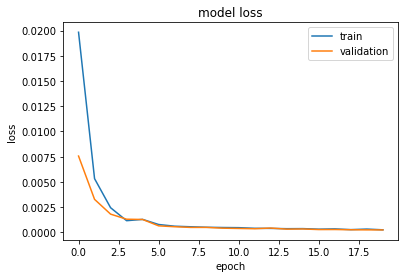

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [14]:
test_sample_index = 122

# select a sample
original_data = test_set[test_sample_index]
original_data.shape

test_data = (original_data - min_value)/(max_value - min_value) # preprocessing
test_data.shape

decoded_data = autoencoder.predict(np.expand_dims(test_data, 0)) 
decoded_data = decoded_data*(max_value-min_value) + min_value   # scale back

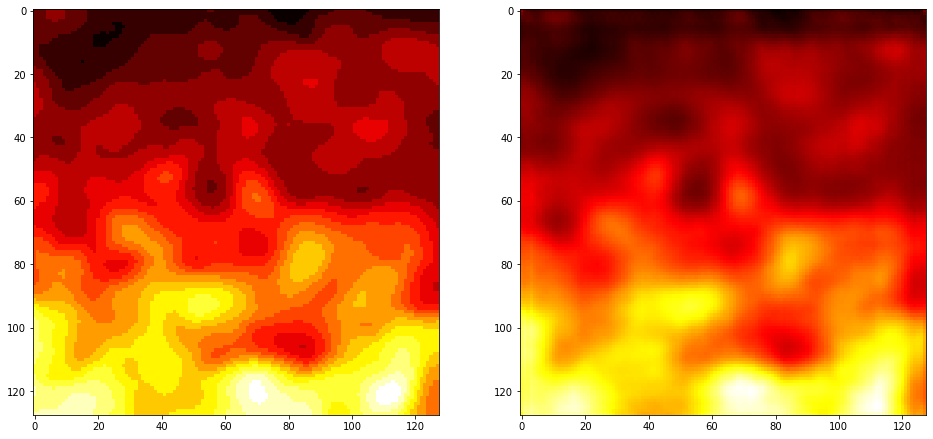

In [15]:
fig = plt.figure(figsize=(16,32)) # image
ax1 = fig.add_subplot(1,2,1) 
ax1.imshow(original_data,cmap='hot')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(decoded_data.reshape(128,128),cmap='hot')

In [16]:
mse = np.square((original_data-decoded_data)).mean()
mse

0.00022489629424193912

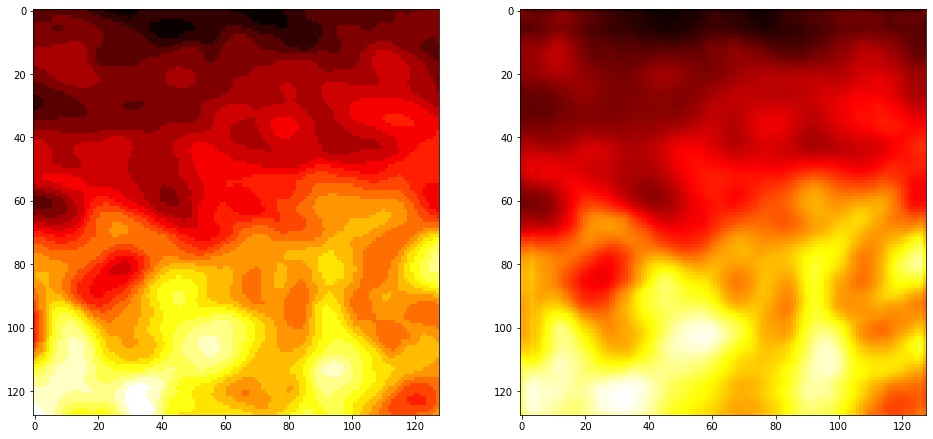

In [17]:
test_sample_index = 110

# select a sample
original_data = test_set[test_sample_index]
original_data.shape

test_data = (original_data - min_value)/(max_value - min_value) # preprocessing
test_data.shape

decoded_data = autoencoder.predict(np.expand_dims(test_data, 0)) 
decoded_data = decoded_data*(max_value-min_value) + min_value   # scale back

fig = plt.figure(figsize=(16,32)) # image
ax1 = fig.add_subplot(1,2,1) 
ax1.imshow(original_data,cmap='hot')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(decoded_data.reshape(128,128),cmap='hot')

In [18]:
mse = np.square((original_data-decoded_data)).mean()
mse

0.0004076826653925995

In [19]:
autoencoder.save("autoencoder(16,16,4) layer(8-5) sample(3000 single region)")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb3 in position 108: invalid start byte